# Gradient Descent vs Gauss-Newton for Global Positioning System (GPS) Location Tracking
Author: David Nobles  
Date: 12/1/2016  
  
### Goal
Find the location of a GPS receiver based on the location and distance information of four satilites.  This is a non-linear-least-squares problem.  We are faced with the task of implementing two algorithms to find the location in 3D space and a clock bias which minimizes the loss function, $l(k)$.

### Procedure
Implement two algorithms and examine their performance.  The first will be a Gradient Descent Algorithm, and the second will be a Gauss-Newton Algorithm.

In [1]:
# import libraries
import numpy as np # vector and matrix math
from numpy.linalg import inv
import matplotlib.pyplot as plt # for plotting
from mpl_toolkits.mplot3d import Axes3D

# functions and definitions
def R(dS):
    return np.sqrt(dS.T.dot(dS))

# 1 Earth-Radii = 6,370km
ER_TO_METERS = 6370000

# Create Simulation Data, with complete knowlege of the system

# true positions
# In the format S = (x, y, z)
S_true = np.array([[1.000000, 0.000000000, 0.000000000]]).T
S_1 = np.array([[3.585200000, 2.070000000, 0.000000000]]).T
S_2 = np.array([[2.927400000, 2.927400000, 0.000000000]]).T
S_3 = np.array([[2.661200000, 0.000000000, 3.171200000]]).T
S_4 = np.array([[1.415900000, 0.000000000, 3.890400000]]).T

# clock bias
b_true = 2.354788068e-3

# generate synthetic data
y = np.ndarray((4,1))
y[0] = R(S_true - S_1) + b_true
y[1] = R(S_true - S_2) + b_true
y[2] = R(S_true - S_3) + b_true
y[3] = R(S_true - S_4) + b_true

# Gradient Descent

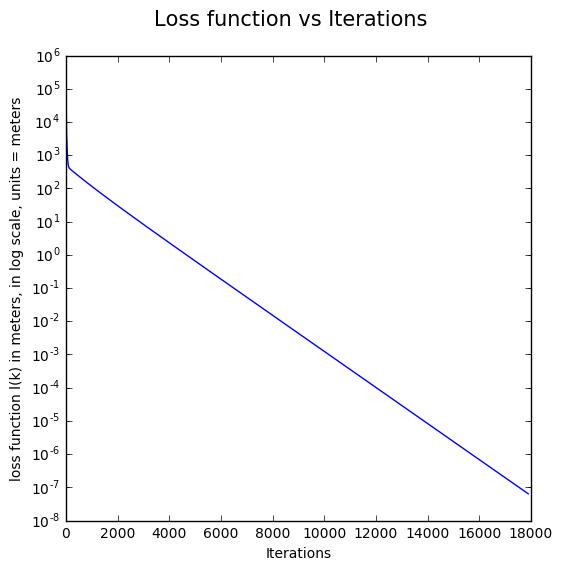

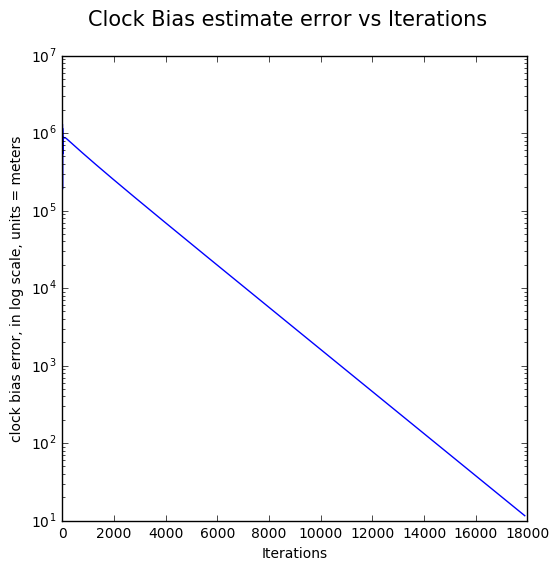

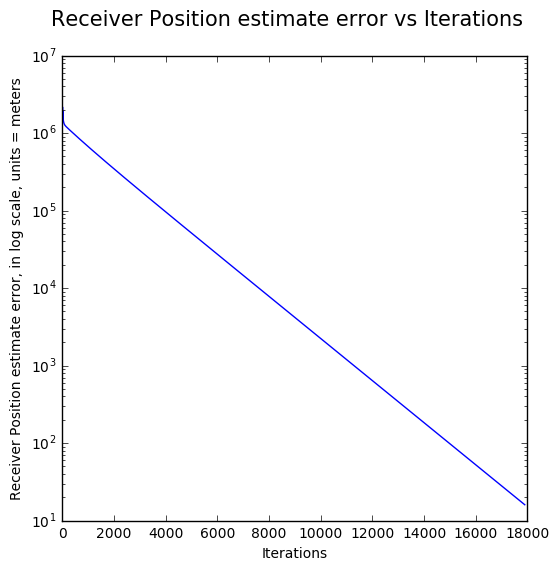

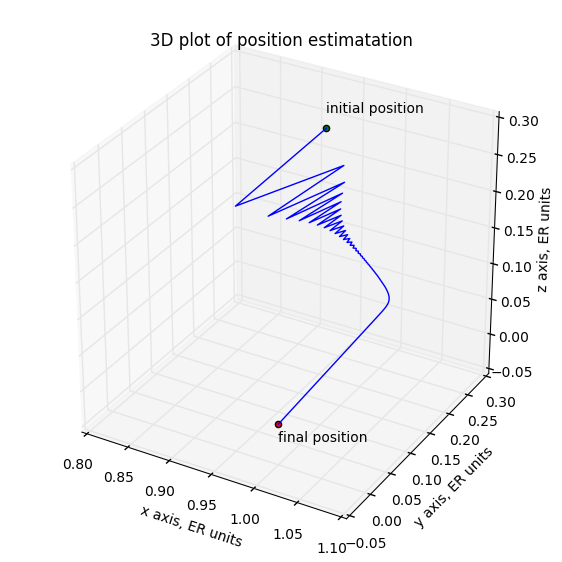

Initial guess is 2.331e+06 meters off of true location
Stepsize = 0.30
After 17894 iterations, there remains 15.983 meters of error


In [2]:
# Now we limit our knowlege to S_1 to S_4, and y_1 to y_4.
# We assume no knowlege of S_true or b_true.

# initial guesses for position and clock bias
b_0 = 0.000
S_0 = np.array([[0.93310, 0.25000, 0.258819]]).T
X_0 = np.vstack((S_0, b_0))

# initialize variables to store error vs iteration, for later plotting
loss = np.ndarray((0))
receiver_error = np.ndarray((0))
clock_error = np.ndarray((0))
X_path = X_0
S_init = S_0

# initialize loop counting and convergance conditions
iterations = 0
conv_condition = 0.01   # we are defining a change of less 1cm to be convergance
dS = conv_condition + 1

# Begin Gradient Descent Algorithm
while dS > conv_condition:
    # construct estimate of distances
    h = np.ndarray((4,1))
    h[0] = R(S_0 - S_1) + b_0
    h[1] = R(S_0 - S_2) + b_0
    h[2] = R(S_0 - S_3) + b_0
    h[3] = R(S_0 - S_4) + b_0

    # construct unit vectors that point in direction of greatest decent for the loss function
    r = np.ndarray((4, 3))
    r[0] = ((S_0 - S_1)/R(S_0 - S_1)).T
    r[1] = ((S_0 - S_2)/R(S_0 - S_2)).T
    r[2] = ((S_0 - S_3)/R(S_0 - S_3)).T
    r[3] = ((S_0 - S_4)/R(S_0 - S_4)).T

    # construct jacobian matrix of the position
    H = np.hstack((r, np.ones((4,1))))

    # define step size a
    a = 0.3

    # Gradient Descent
    X_next = X_0 + a*H.T.dot(y - h)
    dS = R(S_0 - X_next[0:3]) * ER_TO_METERS
    
    # Update Estimates, store X_0 for plotting
    S_0 = X_next[0:3]
    b_0 = X_next[3]
    X_0 = X_next
    X_path = np.hstack((X_path, X_0))
    
    # Store data for plotting
    loss = np.append(loss,  0.5 * (y - h).T.dot(y - h))
    receiver_error = np.append(receiver_error, np.sqrt((S_0 - S_true).T.dot(S_0 - S_true)))
    clock_error = np.append(clock_error, np.abs(b_0 - b_true))
    
    iterations += 1
# End Gradient Descent Algorithm

########################################################################################
########################################################################################

# Examine Results of Gradient Descent
figsize = 6

# Plot loss function
k = range(1, iterations+1)
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, loss*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("loss function l(k) in meters, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Loss function vs Iterations", fontsize=15, ha='center')
plt.show()

# Plot clock bias estimate error 
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, clock_error*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("clock bias error, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Clock Bias estimate error vs Iterations", fontsize=15, ha='center')
plt.show()

# Plot receiver position estimate error
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, receiver_error*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("Receiver Position estimate error, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Receiver Position estimate error vs Iterations", fontsize=15, ha='center')
plt.show()

# 3D Plot of position
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_path[0,], X_path[1,], X_path[2,])
ax.scatter(S_init[0], S_init[1], S_init[2], c='green', marker='o', s=20)
ax.scatter(S_true[0], S_true[1], S_true[2], c='red', marker='o', s=20)
ax.set_xlabel("x axis, ER units")
ax.set_ylabel("y axis, ER units")
ax.set_zlabel("z axis, ER units")
ax.set_title("3D plot of position estimatation")
ax.text3D(0.93310, 0.25000, 0.28, "initial position", None)
ax.text3D(1, 0, -.025, "final position", None)
plt.show()

# Print initial reciever error
print("Initial guess is %.3e meters off of true location" % (R(S_init - S_true) * ER_TO_METERS) )

# Print final reciever error
error = R(S_true - S_0) * ER_TO_METERS
print("Stepsize = %.2f" % a)
print("After %d iterations, there remains %.3f meters of error" % (iterations, error))

### Comments  
For a large step size, $a_k = 0.3$ the algorithm clearly jitters back and forth between values, creating a very slow desent.  Larger values of $a_k$ tend to make the algorithm unstable.  Smaller values of $a_k$ slow the convergance to require an unreasonable number of iterations.  Also, notice that the path taken is not a straight path to the final position.

# Gauss-Newton

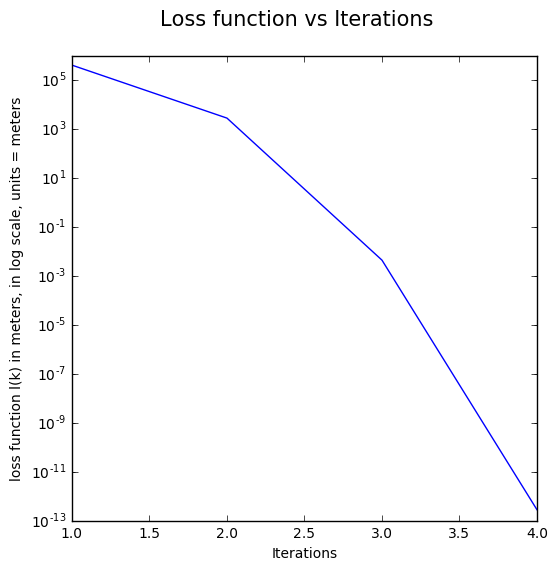

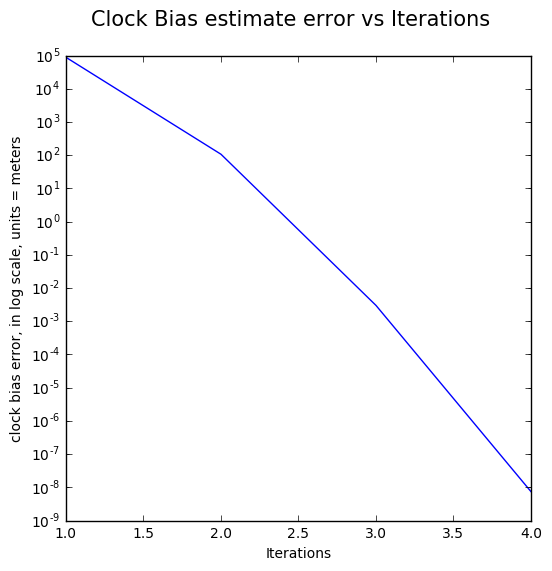

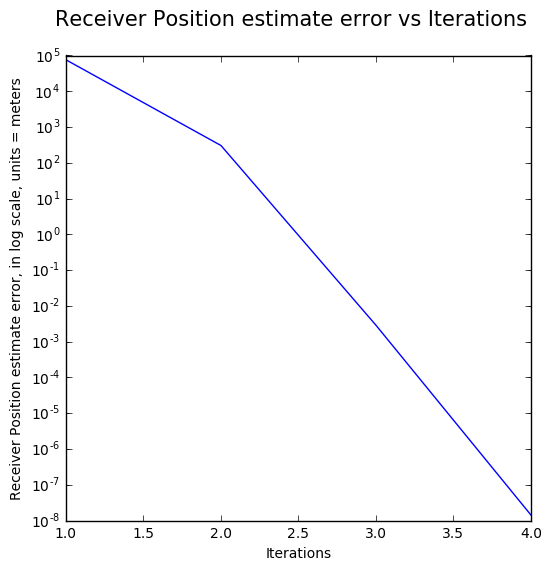

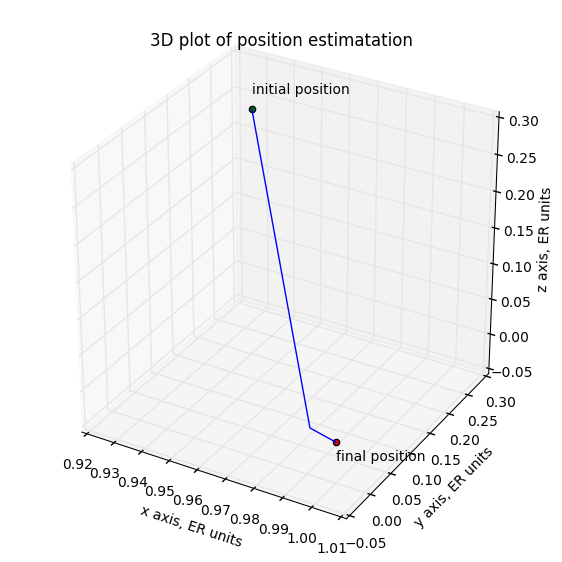

Initial guess is 2.331e+06 meters off of true location
Stepsize = 1.00
After 4 iterations, there remains 0.000 meters of error


In [3]:
# Now we limit our knowlege to S_1 to S_4, and y_1 to y_4.
# We assume no knowlege of S_true or b_true.

# initial guesses for position and clock bias
b_0 = 0.000
S_0 = np.array([[0.93310, 0.25000, 0.258819]]).T
X_0 = np.vstack((S_0, b_0))

# initialize variables to store error vs iteration, for later plotting
loss = np.ndarray((0))
receiver_error = np.ndarray((0))
clock_error = np.ndarray((0))
X_path = X_0
S_init = S_0

# initialize loop counting and convergance conditions
iterations = 0
conv_condition = 0.01   # we are defining a change of less 1cm to be convergance
dS = conv_condition + 1

# Begin Gradient Descent Algorithm
while dS > conv_condition:
    # construct estimate of distances
    h = np.ndarray((4,1))
    h[0] = R(S_0 - S_1) + b_0
    h[1] = R(S_0 - S_2) + b_0
    h[2] = R(S_0 - S_3) + b_0
    h[3] = R(S_0 - S_4) + b_0

    # construct unit vectors that point in direction of greatest decent for the loss function
    r = np.ndarray((4, 3))
    r[0] = ((S_0 - S_1)/R(S_0 - S_1)).T
    r[1] = ((S_0 - S_2)/R(S_0 - S_2)).T
    r[2] = ((S_0 - S_3)/R(S_0 - S_3)).T
    r[3] = ((S_0 - S_4)/R(S_0 - S_4)).T

    # construct jacobian matrix of the position
    H = np.hstack((r, np.ones((4,1))))

    # define step size a
    a = 1.0

    # Gradient Descent
    X_next = X_0 + a*inv(H).dot(y - h)
    dS = R(S_0 - X_next[0:3]) * ER_TO_METERS
    
    # Update Estimates, store X_0 for plotting
    S_0 = X_next[0:3]
    b_0 = X_next[3]
    X_0 = X_next
    X_path = np.hstack((X_path, X_0))
    
    # Store data for plotting
    loss = np.append(loss,  0.5 * (y - h).T.dot(y - h))
    receiver_error = np.append(receiver_error, np.sqrt((S_0 - S_true).T.dot(S_0 - S_true)))
    clock_error = np.append(clock_error, np.abs(b_0 - b_true))
    
    iterations += 1
# End Gradient Descent Algorithm

########################################################################################
########################################################################################

# Examine Results of Gradient Descent
figsize = 6

# Plot loss function
k = range(1, iterations+1)
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, loss*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("loss function l(k) in meters, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Loss function vs Iterations", fontsize=15, ha='center')
plt.show()

# Plot clock bias estimate error 
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, clock_error*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("clock bias error, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Clock Bias estimate error vs Iterations", fontsize=15, ha='center')
plt.show()

# Plot receiver position estimate error
plt.figure(figsize=(figsize,figsize))
plt.semilogy(k, receiver_error*ER_TO_METERS)
plt.xlabel("Iterations")
plt.ylabel("Receiver Position estimate error, in log scale, units = meters")
plt.figtext(0.5, 0.95,"Receiver Position estimate error vs Iterations", fontsize=15, ha='center')
plt.show()

# 3D Plot of position
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_path[0,], X_path[1,], X_path[2,])
ax.scatter(S_init[0], S_init[1], S_init[2], c='green', marker='o', s=20)
ax.scatter(S_true[0], S_true[1], S_true[2], c='red', marker='o', s=20)
ax.set_xlabel("x axis, ER units")
ax.set_ylabel("y axis, ER units")
ax.set_zlabel("z axis, ER units")
ax.set_title("3D plot of position estimatation")
ax.text3D(0.93310, 0.25000, 0.28, "initial position", None)
ax.text3D(1, 0, -.025, "final position", None)
plt.show()

# Print initial reciever error
print("Initial guess is %.3e meters off of true location" % (R(S_init - S_true) * ER_TO_METERS) )

# Print final reciever error
error = R(S_true - S_0) * ER_TO_METERS
print("Stepsize = %.2f" % a)
print("After %d iterations, there remains %.3f meters of error" % (iterations, error))

# Conclusion  
  
Clearly the Gauss-Newton has superior performance over Gradient Descent. In as little as 4 iterations, Gauss-Newton converges to a location that is within less than 1mm of the true location. Of course this data was artificially generated with no noise, and in real-world scenarios, the convergence would not be this good. Regardless, it is clear that Gauss-Newton is significantly better than Gradient-Descent, in the case of GPS positioning.